# Identify mRNA VV-type motifs in human genome

### Globals

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(111)
from Bio.Seq import Seq
# for reading FASTA files
import pyfaidx
# for reading GFF3 files
import gffpandas.gffpandas as gffpd
# for plotting
import plotnine as pn

from plotnine import ggplot,aes,facet_wrap,geom_histogram
pd.set_option('display.max_rows', 10)

ccdsseqs = pyfaidx.Fasta('../data/gencode/gencode.v32.canonical_ccds.fa')

## Read in transcript annotations

In [3]:
annotations = pd.read_table("../data/gencode/gencode.v32.canonical_ccds.parameters.tsv.gz")
annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19174 entries, 0 to 19173
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transcript_id  19174 non-null  object
 1   utr5_length    19174 non-null  int64 
 2   cds_length     19174 non-null  int64 
 3   utr3_length    19174 non-null  int64 
 4   gene_id        19174 non-null  object
 5   gene_name      19174 non-null  object
 6   ccdsid         18751 non-null  object
dtypes: int64(3), object(4)
memory usage: 1.0+ MB


### Convert each CCDS into a sequence of dicodon scores

In [4]:
stall_dipeptides = ['LL', 'LV', 'LI', 'LY', 'LF',
                    'VL', 'VI', 'VV', 'VY', 'VF',
                    'IL', 'IV', 'II', 'IY', 'IF',
                    'YL', 'YV', 'YI', 'YY', 'YF',
                    'FL', 'FV', 'FI', 'FY', 'FF']

In [5]:
ccds_dicodon_scores = dict()
for tx in ccdsseqs.keys():
    ccds_dicodon_scores[tx] = np.zeros(int(len(ccdsseqs[tx])/3) - 1)
    aa_seq = str(Seq(str(ccdsseqs[tx])).translate())
    dipeptide_score = 0
    for pos, n in enumerate(range(len(aa_seq) - 1)):
        new_dipeptide = aa_seq[pos:pos+2]
        if new_dipeptide in stall_dipeptides:
            # give higher weight if you have two consecutive dipeptides
            dipeptide_score += 1
            ccds_dicodon_scores[tx][pos] = min(dipeptide_score, 2)
        else:
            dipeptide_score = 0

/fh/fast/subramaniam_a/user/rasi/lib/miniconda3/lib/python3.7/site-packages/Bio/Seq.py:2338: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


In [6]:
len(ccds_dicodon_scores)

19174

## Find the window with highest and lowest dicodon scores

In [7]:
scores = list()
window_size = 16 # amino acid units
control_max_score = 2

for tx in ccds_dicodon_scores:
    convolution = np.convolve(ccds_dicodon_scores[tx], np.ones(window_size), mode='same')
    # maximum dicodon score
    stall_loc = convolution.argmax()
    scores.append({'transcript_id': tx, 
                   'strength': convolution[stall_loc], 
                   'loc': stall_loc,
                   'motif': str(Seq(str(ccdsseqs[tx][int(3*(stall_loc-window_size/2-4)):int(3*(stall_loc+window_size/2+4))])).translate()),
                   'nt72': str(ccdsseqs[tx][int(3*(stall_loc-window_size/2-4)):int(3*(stall_loc+window_size/2+4))]),
                   'motif_type': 'stall'})
    control_locs = np.nonzero(convolution <= control_max_score)[0]
    # only include control_locs away from edges of CDS
    control_locs = control_locs[((control_locs >= window_size) & (control_locs < (len(convolution) - window_size)))]
    if len(control_locs) == 0:
        continue
    # pick one of the control locs randomly
    control_loc = int(np.random.choice(control_locs))
    # use the convolution strength at this location
    scores.append({'transcript_id': tx, 
                   'strength': convolution[control_loc], 
                   'loc': control_loc, 
                   'motif': str(Seq(str(ccdsseqs[tx][int(3*(control_loc-window_size/2-4)):int(3*(control_loc+window_size/2+4))])).translate()),
                   'nt72': str(ccdsseqs[tx][int(3*(control_loc-window_size/2-4)):int(3*(control_loc+window_size/2+4))]),
                   'motif_type': 'control'})
    
scores = pd.DataFrame(scores)

## Plot the distribution of minimum dicodon scores for CCDS

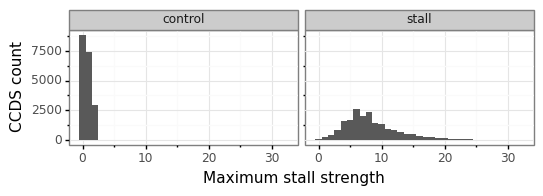

<ggplot: (8769453583813)>

In [8]:
(
    ggplot(scores, aes(x='strength')) +
    facet_wrap(facets=['motif_type']) +
    geom_histogram(binwidth=1) +
    pn.labs(x='Maximum stall strength', y='CCDS count') +
    pn.theme_bw()+
    pn.theme(figure_size=(6,1.5))
)

## How many genes have VV-type motifs of a certain strength?

In [9]:
pd.set_option('display.max_rows', 20)
(
    scores
    .assign(strength = lambda x: x.strength.astype('int'))
    .query('motif_type == "stall"')
    .groupby('strength')
    .count()
    .loc[:, ['transcript_id']]
    .query('strength >= 10')
    .sum()
)

transcript_id    6043
dtype: int64

## Write processed data to TSV for downstream use

In [10]:
(
    scores
    .merge(annotations, on='transcript_id').drop('gene_id', axis=1)
    .reset_index()
    # go from amino acid loc in CDS to nucleotide loc in trancript
    .assign(loc = lambda x: 3*x['loc'] + x['utr5_length'])
    .loc[:, ['gene_name', 'transcript_id', 'loc', 'motif', 'strength', 'motif_type', 'nt72']]
    .to_csv('../data/motif_counts/vv_motifs.tsv.gz', sep = '\t', index=False)
)